# Modelo de classificação: XGBoost

## Carregando dados

In [1]:
import pandas as pd

# carregando dados
dados = pd.read_excel("dados/dados_escores_processados.xlsx")
dados.head()

,Ponto,PontoID,Data,Campo,Equipe,Especie01,Avaliador,Altura,EstDesenv,Invasoras,Cupins,CobertSolo,DispForr,DispFolhVerd,CondAtual,PotProd,Degrad,Manejo
0,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Maria Eduarda Passos,17.4,3.5,4.0,2.5,5.0,3.5,3.0,2.5,3.0,3.5,2.5
1,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,João Abrão,17.4,3.5,4.5,3.0,4.5,3.5,3.5,3.0,3.5,3.5,2.5
2,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Lara Guilarducci,17.4,3.5,4.5,3.5,5.5,3.0,2.5,3.0,3.5,3.0,3.0
3,M1001-E1-P1,750,2022-03-20,2,1,Brachiaria brizantha,Victor,17.4,3.5,3.5,3.0,5.0,3.0,3.0,3.0,3.0,3.5,2.5
4,M1001-E1-P3,748,2022-03-20,2,1,Brachiaria brizantha,João Abrão,23.0,5.0,2.0,2.0,4.0,3.0,3.0,3.5,4.0,2.5,3.5


## Preparando variáveis preditoras

In [2]:
import numpy as np

# função que calcula diferença entre max e min
def max_min_diff(x):
    return np.max(x) - np.min(x)

# separando coluna de escores
escores = [col for col in dados.columns if col not in ["Ponto", "PontoID", "Data", "Campo", "Equipe",
                                                                     "Especie01", "Avaliador"]]

# agrupando dados por id dos pontos e aplicando funções mean, min, max e max_min_diff para servirem
# como variaveis preditoras
#dados = dados.groupby("PontoID")[escores].agg([np.mean, np.min, np.max, max_min_diff])
dados = dados.groupby("PontoID")[escores].agg([np.mean])
dados.columns = [col + "_" + func for col, func in zip(dados.columns.get_level_values(0), dados.columns.get_level_values(1))]
dados.head(10)

,Altura_mean,EstDesenv_mean,Invasoras_mean,Cupins_mean,CobertSolo_mean,DispForr_mean,DispFolhVerd_mean,CondAtual_mean,PotProd_mean,Degrad_mean,Manejo_mean
PontoID,,,,,,,,,,,
0,39.84,2.975,1.833333,1.083333,4.333333,3.541667,3.875,4.291667,4.833333,1.416667,4.833333
1,7.40,1.875,6.125000,1.625000,1.625000,1.000000,1.000,1.000000,1.375000,6.375000,1.000000
3,12.50,2.375,3.000000,1.625000,2.000000,1.625000,1.250,1.250000,1.625000,4.750000,1.500000
6,15.30,2.250,3.250000,2.125000,3.625000,2.625000,2.625,2.750000,3.750000,2.875000,2.625000
9,8.90,2.000,5.250000,1.000000,1.375000,1.250000,1.125,1.250000,1.375000,6.375000,1.000000
13,7.90,1.875,5.500000,1.000000,1.750000,1.125000,1.125,1.125000,1.375000,6.125000,1.000000
16,50.30,3.250,2.625000,1.000000,2.375000,3.750000,3.500,2.250000,2.875000,3.250000,1.875000
17,7.10,1.875,4.125000,3.000000,2.125000,1.875000,1.750,1.625000,2.000000,5.000000,1.375000
18,12.70,3.125,3.125000,2.000000,4.375000,3.500000,4.000,2.875000,3.500000,2.875000,2.375000


## Carregando "rótulos" de degradação da pastagem

In [3]:
dados_classe = pd.read_excel("dados/dados_geoloc_classe.xlsx")
dados_classe.index = dados_classe["PontoID"]
dados_classe.drop(columns="PontoID", inplace=True)
dados_classe.head(10)

,Ponto,LON,LAT,REGIAO,UF,ESTADO,gridM_ID,gridG_ID,LOCCLASS,CLASS_DED
PontoID,,,,,,,,,,
750,M1001-E1-P1,-50.832922,-15.398786,Centro-Oeste,GO,Goiás,M1001,G15,outside,Degradação Moderada
748,M1001-E1-P3,-50.769860,-15.478017,Centro-Oeste,GO,Goiás,M1001,G15,inside,Degradação Baixa
713,M1009-E3-P1,-50.814776,-16.118247,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Agrícola Severa
708,M1009-E3-P2,-50.831664,-16.168822,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Baixa
706,M1009-E3-P3,-50.822681,-16.188046,Centro-Oeste,GO,Goiás,M1009,G15,outside,Degradação Moderada
705,M1009-E3-P4,-50.788635,-16.193076,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Baixa
710,M1009-E3-P6,-50.780460,-16.160647,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Moderada
711,M1009-E3-P7,-50.780371,-16.159300,Centro-Oeste,GO,Goiás,M1009,G15,inside,Degradação Moderada
709,M1009-E3-P8,-50.769232,-16.163611,Centro-Oeste,GO,Goiás,M1009,G15,outside,Degradação Moderada


## Join dos rótulos com os dados iniciais

In [4]:
dados = dados.join(dados_classe[["CLASS_DED"]], how="inner")
dados.head(10)

,Altura_mean,EstDesenv_mean,Invasoras_mean,Cupins_mean,CobertSolo_mean,DispForr_mean,DispFolhVerd_mean,CondAtual_mean,PotProd_mean,Degrad_mean,Manejo_mean,CLASS_DED
PontoID,,,,,,,,,,,,
1,7.4,1.875,6.125,1.625,1.625,1.000,1.000,1.000,1.375,6.375,1.000,Degradação Biológica Severa
3,12.5,2.375,3.000,1.625,2.000,1.625,1.250,1.250,1.625,4.750,1.500,Degradação Biológica Severa
6,15.3,2.250,3.250,2.125,3.625,2.625,2.625,2.750,3.750,2.875,2.625,Degradação Moderada
9,8.9,2.000,5.250,1.000,1.375,1.250,1.125,1.250,1.375,6.375,1.000,Degradação Biológica Severa
13,7.9,1.875,5.500,1.000,1.750,1.125,1.125,1.125,1.375,6.125,1.000,Degradação Biológica Severa
16,50.3,3.250,2.625,1.000,2.375,3.750,3.500,2.250,2.875,3.250,1.875,Degradação Biológica Severa
17,7.1,1.875,4.125,3.000,2.125,1.875,1.750,1.625,2.000,5.000,1.375,Degradação Biológica Severa
18,12.7,3.125,3.125,2.000,4.375,3.500,4.000,2.875,3.500,2.875,2.375,Degradação Moderada
19,6.8,2.125,1.625,2.125,3.625,2.375,1.750,2.125,2.750,3.625,1.625,Degradação Moderada


## Qual a distribuição dos rótulos?

In [5]:
dados["CLASS_DED"].value_counts()

CLASS_DED
Degradação Moderada            201
Degradação Baixa                88
Não degradada                   67
Degradação Agrícola Severa      53
Degradação Biológica Severa     51
Name: count, dtype: int64

Da tabela acima, notamos que existe um desbalanceamento grande de classes, com a classe "Degradação Moderada" sendo maioria. Para os propósitos deste trabalho, vou agrupar as classes "Não degradada" e "Degradação Baixa" como a classe negativa e o restante das classes como a classe positiva.

## Por curiosidade: como os rótulos se relacionam com as variáveis "Degrad_mean" e "Manejo_mean"?

**Para "Degrad_mean"**

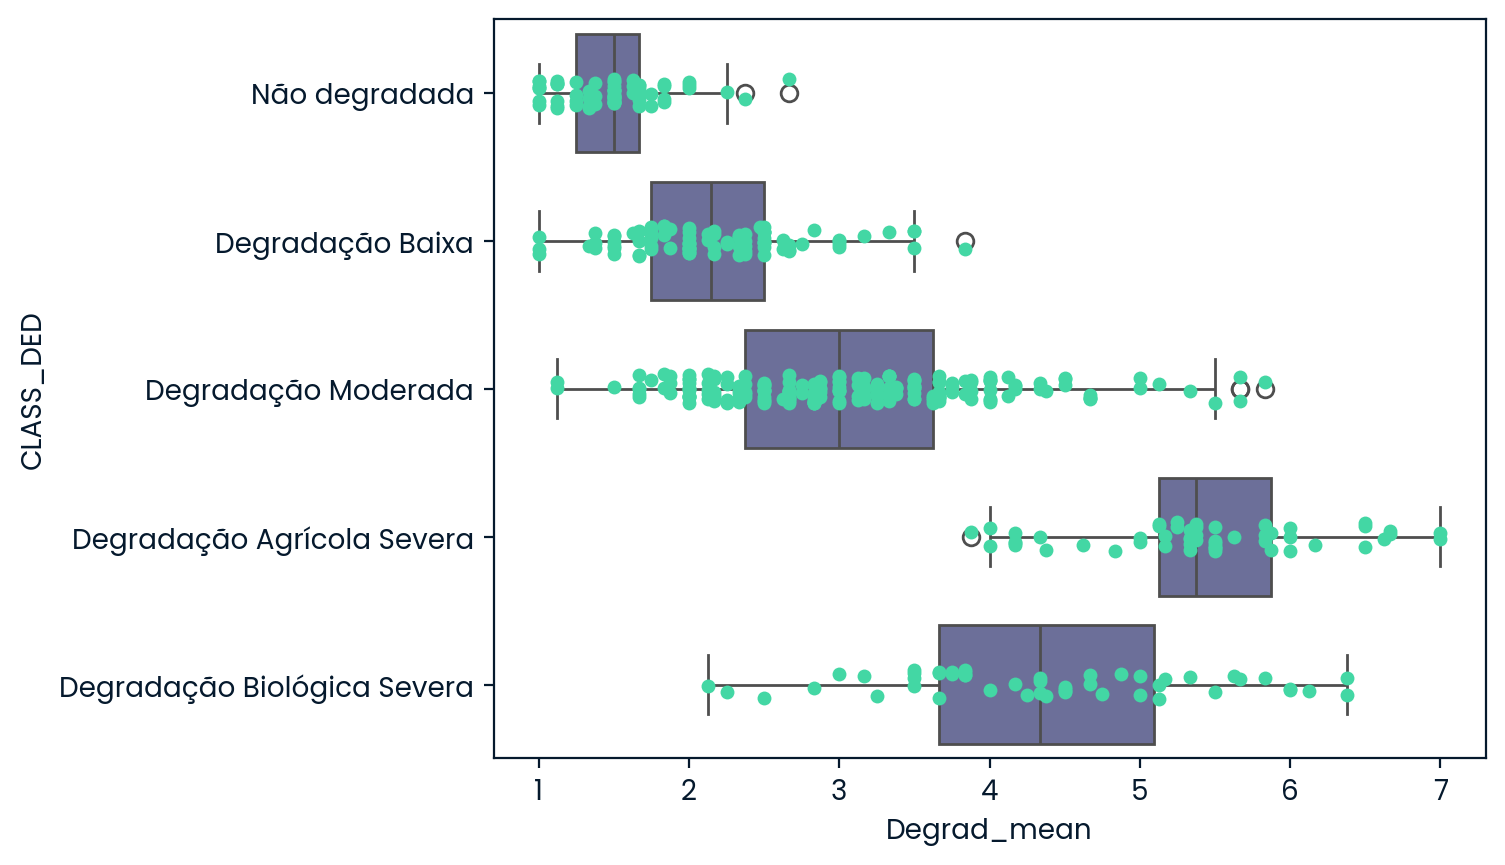

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.boxplot(dados, y="CLASS_DED", x="Degrad_mean", order=["Não degradada", "Degradação Baixa",
                                                               "Degradação Moderada", "Degradação Agrícola Severa",
                                                               "Degradação Biológica Severa"])
sns.stripplot(dados, y="CLASS_DED", x="Degrad_mean", order=["Não degradada", "Degradação Baixa",
                                                               "Degradação Moderada", "Degradação Agrícola Severa",
                                                               "Degradação Biológica Severa"], ax=ax)
plt.show()

**Para "Manejo_mean"**

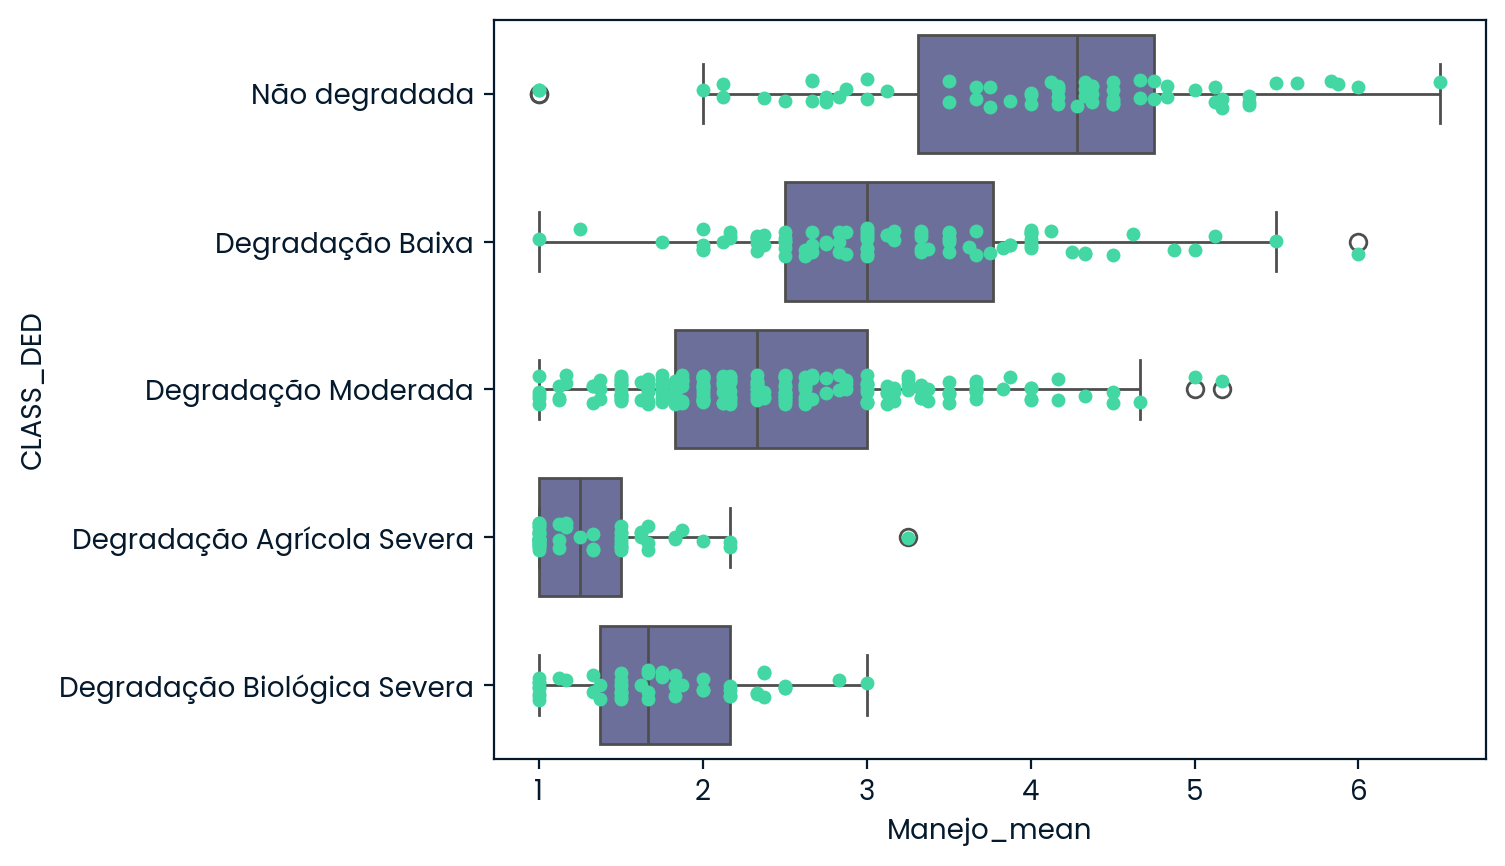

In [7]:
ax = sns.boxplot(dados, y="CLASS_DED", x="Manejo_mean", order=["Não degradada", "Degradação Baixa",
                                                               "Degradação Moderada", "Degradação Agrícola Severa",
                                                               "Degradação Biológica Severa"])
sns.stripplot(dados, y="CLASS_DED", x="Manejo_mean", order=["Não degradada", "Degradação Baixa",
                                                               "Degradação Moderada", "Degradação Agrícola Severa",
                                                               "Degradação Biológica Severa"], ax=ax)
plt.show()

Vemos que essas variáveis estão fortemente correlacionadas com as respectivas classes, de modo que não existe graça em incluí-las no modelo de classificação como features preditores. Nesse sentido, trabalharemos sem essas duas variáveis.

## Preparando X_train, X_test, y_train, y_test

Variável de saída: y

In [8]:
y = (~dados["CLASS_DED"].isin(["Não degradada", "Degradação Baixa"])*1).values
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

Variável de entrada: X

In [9]:
#X = dados.drop(columns=["CLASS_DED"]).values
X = dados.drop(columns=["CLASS_DED"] + [col for col in dados.columns\
                                        if "Degrad" in col or "Manejo" in col]).values
X[:, :10]

array([[ 7.4  ,  1.875,  6.125, ...,  1.   ,  1.   ,  1.375],
       [12.5  ,  2.375,  3.   , ...,  1.25 ,  1.25 ,  1.625],
       [15.3  ,  2.25 ,  3.25 , ...,  2.625,  2.75 ,  3.75 ],
       ...,
       [24.6  ,  4.375,  1.375, ...,  3.625,  3.875,  4.375],
       [23.   ,  4.875,  2.125, ...,  2.875,  3.375,  4.   ],
       [17.4  ,  3.5  ,  4.125, ...,  3.   ,  2.875,  3.25 ]])

Divisão dos dados em dados de treino e dados de teste.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=667)

print(f"Total de pontos reservados para treino: {len(X_train)}")
print(f"Total de pontos reservados para teste: {len(X_test)}")

Total de pontos reservados para treino: 322
Total de pontos reservados para teste: 138


## Otimização de hiperparâmetros e treinamento do modelo de classificação

In [11]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable


Para a tunagem de hiperparâmetros, será utilizado o otimizador de Bayes, que faz uso da regra de Bayes para buscar a melhor combinação de hiperparâmetros com base nos resultados provenientes de validação cruzada. Usaremos K-Fold estratificado (para manter as classes balanceadas) com K = 5, para termos uma boa estatística.

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

np.int = int

param_distributions = {"max_depth": Integer(2, 100),
                       "colsample_bytree": Real(.1, 1),
                       "scale_pos_weight": Real(1, 50),
                       "learning_rate": Real(1e-4, 1.5, prior="log-uniform"),
                       "reg_alpha": Real(1e-5, 10, prior="log-uniform"),
                       "reg_lambda": Real(1e-5, 10, prior="log-uniform")}

model = XGBClassifier(n_estimators=500)

bs_model = BayesSearchCV(model,
                         param_distributions,
                         cv=StratifiedKFold(n_splits=5),
                         n_iter=30,
                         n_jobs=1,
                         random_state=668,
                         verbose=3,
                         scoring=make_scorer(f1_score))

bs_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7266112343209937, learning_rate=0.23039319756971544, max_depth=74, reg_alpha=1.628550033229042, reg_lambda=0.02970994778829138, scale_pos_weight=1.2837334081886373;, score=0.976 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7266112343209937, learning_rate=0.23039319756971544, max_depth=74, reg_alpha=1.628550033229042, reg_lambda=0.02970994778829138, scale_pos_weight=1.2837334081886373;, score=0.988 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7266112343209937, learning_rate=0.23039319756971544, max_depth=74, reg_alpha=1.628550033229042, reg_lambda=0.02970994778829138, scale_pos_weight=1.2837334081886373;, score=0.965 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7266112343209937, learning_rate=0.23039319756971544, max_depth=74, reg_alpha=1.628550033229042, reg_lambda=0.02970994778829138, scale_pos_weight=1.2837334081886373;, score=1.000 total time=   0.1s
[CV 5/5] END colsample_by

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance...
                             'learning_rate': Real(low=0.0001, high=1.5, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-05, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-05, high=10, prior='log-uniform', transform='normalize'),
                             'scale_pos_weight': Real(low=1, high=50, prior='uniform', transform='normalize')},
              verbose=3)

Com o modelo de classificação com a melhor combinação de hiperparâmetros, basta aplicá-lo sobre os dados de teste e calcular as métricas de classificação.

In [13]:
from sklearn.metrics import classification_report

y_pred = bs_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9787    1.0000    0.9892        46
           1     1.0000    0.9891    0.9945        92

    accuracy                         0.9928       138
   macro avg     0.9894    0.9946    0.9919       138
weighted avg     0.9929    0.9928    0.9928       138



Agora vou salvar esse modelo para que eu possa utilizá-lo depois.

In [14]:
import dill

with open("melhor_modelo.pk", "wb") as file:
            dill.dump(bs_model, file)

## Quais são as variáveis preditoras mais importantes e como se relacionam com a degradação das pastagens?

In [15]:
!pip install shap==0.45.0

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 29.0 MB/s eta 0:00:00


In [16]:
import shap

X_pd = pd.DataFrame(X, columns=dados.drop(columns=["CLASS_DED"] + [col for col in dados.columns\
                                                                   if "Degrad" in col or "Manejo" in col]).columns)
explainer = shap.TreeExplainer(bs_model.best_estimator_)
shap_values = explainer.shap_values(X_pd)

Valores SHAP positivos indicam contribuição positiva para a probabilidade de degradação da pastagem. Valores em vermelho indicam valores altos para as variáveis preditoras.

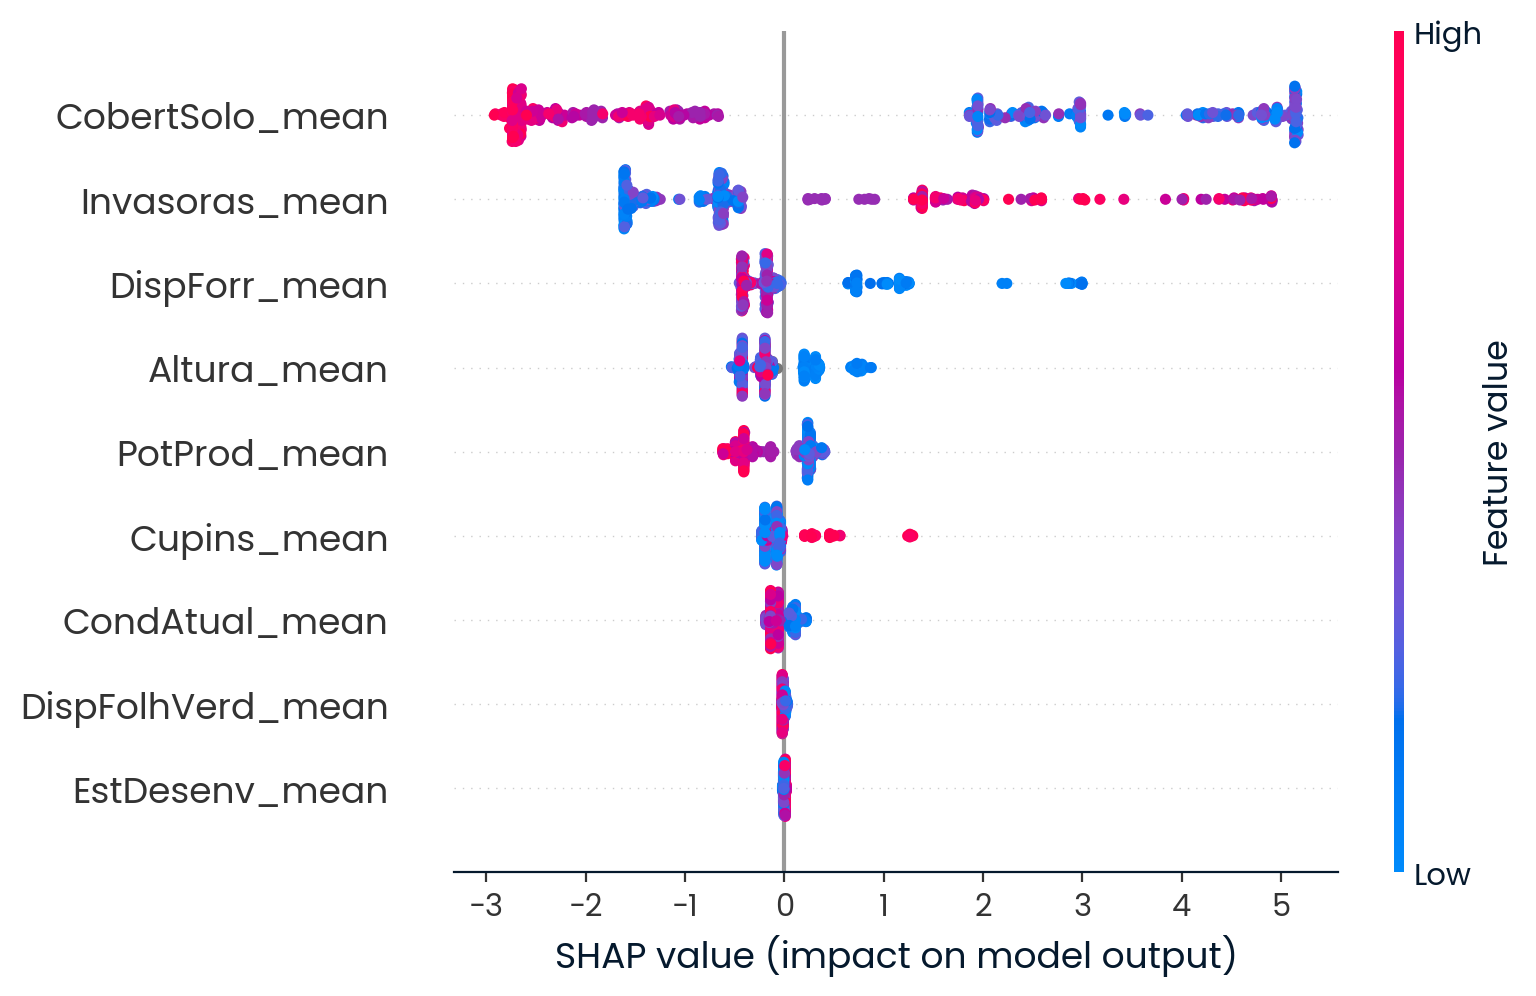

In [17]:
shap.summary_plot(shap_values, X_pd)

In [18]:
shap.force_plot(explainer.expected_value, shap_values, X)